# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
!echo "Started running on $(hostname -s) at $(date -Is)"
!echo "Submitted from host $SLURM_SUBMIT_HOST to node(s) $SLURM_JOB_NODELIST"
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50' # NOTE: jax preallocates GPU (default 75%)
import jax; print(jax.default_backend())

import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

Started running on feynmangpu04 at 2024-12-11T18:32:26+01:00
Submitted from host feynmannode11.cluster.local to node(s) feynmangpu04
gpu


2024-12-11 18:32:29.800657: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Config and fiduc

In [ ]:
# Config
save_dir = os.path.expanduser("~/scratch/pickles/")
config = {
          # Mesh and box parameters
          'mesh_shape':3 * (64,), # int
          'box_shape':3 * (640.,), # in Mpc/h (aim for cell lengths between 1 and 10 Mpc/h)
          # LSS formation
          'a_lpt':0.1,
          'lpt_order':1,
          'precond':3,
          }

# Load and save model
model = FieldLevelModel(**default_config | config)
def get_save_dir(**kwargs):
    dir = os.path.expanduser("~/scratch/pickles/")
    # dir = os.path.expanduser("/lustre/fsn1/projects/rech/fvg/uvs19wt/pickles/")
    dir += f"m{kwargs['mesh_shape'][0]:d}_b{kwargs['box_shape'][0]:.1f}"
    dir += f"_al{kwargs['a_lpt']:.1f}_ao{kwargs['a_obs']:.1f}_lo{kwargs['lpt_order']:d}_pc{kwargs['precond']:d}_ob{kwargs['obs']}/"
    return dir
save_dir = get_save_dir(**model.__dict__)
# print(model)
# model.render(0,1)

if not os.path.exists(save_dir):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, frombase=True)

    if model.precond==3:
        model.obs_meshk = truth['obs']
        truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
        truth = model.predict(samples=truth, hide_base=False, frombase=True)
        print("rerun diff", ((jnp.fft.irfftn(model.obs_meshk) - truth['obs'])**2).max())

    print(f"Saving model and truth at {save_dir}")
    os.mkdir(save_dir)
    model.save(save_dir)    
    pdump(truth, save_dir + "truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir + "truth.p")

model.condition({'obs': truth['obs']})
model.block()
# model.render(0,1)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b640.0_al0.1_ao0.5_lo1_pc3_obmesh/


In [42]:
from montecosmo.mcbench import Samples
params_ = Samples(truth, model.groups | model.groups_)[['cosmo_','init_']].data
params = model.reparam(params_)
params2_ = model.reparam(params, inv=True)
params2 = model.reparam(params2_)
mse_fn = lambda x,y: ((x-y)**2).mean()
tree.map(mse_fn,params2, params), tree.map(mse_fn, params2_, params_)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

({'Omega_m': Array(0., dtype=float32),
  'init_mesh': Array(-7.440555e-14+3.259694e-12j, dtype=complex64),
  'sigma8': Array(0., dtype=float32)},
 {'Omega_m_': Array(0., dtype=float32),
  'init_mesh_': Array(6.7073295e-15, dtype=float32),
  'sigma8_': Array(5.585864e-15, dtype=float32)})

In [50]:
meshes = []
for pc in [0,1,2,3]:
    dir = get_save_dir(**model.__dict__ | {'precond':pc})
    # mesh = jnp.fft.irfftn(pload(dir + "truth.p")['init_mesh'])
    mesh = pload(dir + "truth.p")['obs']
    meshes.append(mesh)

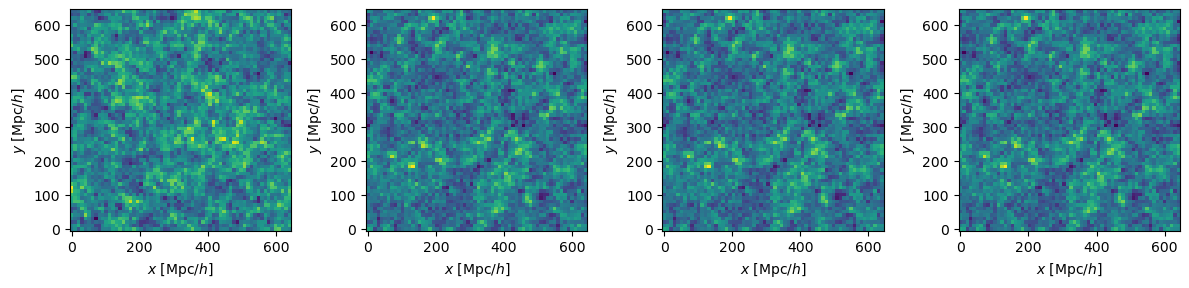

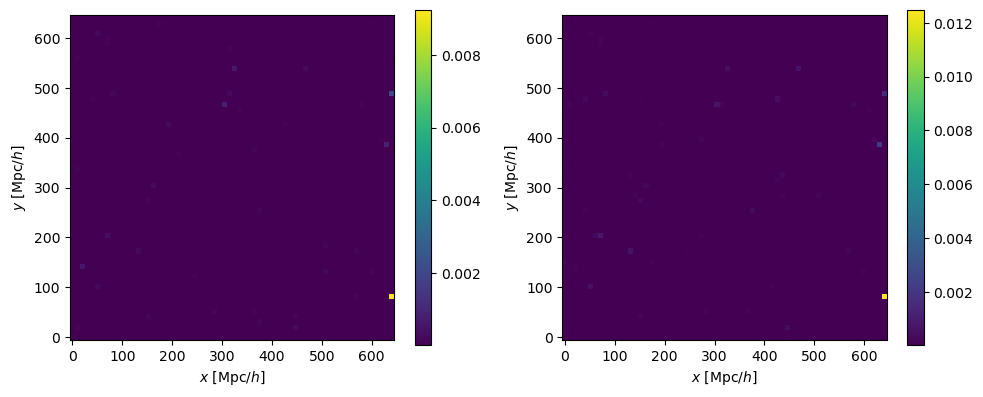

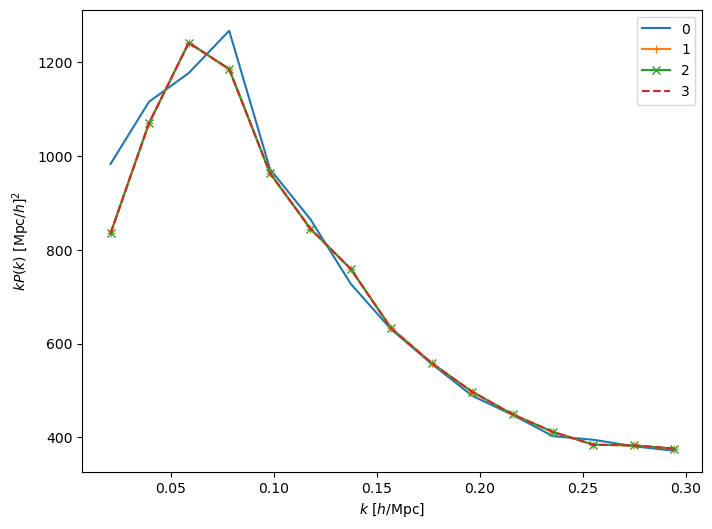

In [51]:
from montecosmo.plot import plot_mesh, plot_pk, plot_bivar
plt.figure(figsize=(12, 6))
for i_plt, mesh in enumerate(meshes):
    plt.subplot(1,len(meshes),i_plt+1)
    plot_mesh(mesh, model.box_shape)
plt.tight_layout()

plt.figure(figsize=(10, 4))
# plot_bivar(relerr, 3)
relerr = lambda x,y: jnp.abs(x-y)/(jnp.abs(x)+jnp.abs(y))
plt.subplot(121)
plot_mesh(relerr(meshes[1], meshes[2]), model.box_shape)
plt.colorbar()
plt.subplot(122)
plot_mesh(relerr(meshes[1], meshes[3]), model.box_shape)
plt.colorbar()
plt.tight_layout()

plt.figure(figsize=(8, 6))
cs = ['', '-+', '-x', '--']
for i_plt, mesh in enumerate(meshes):
    kpk = model.spectrum(mesh)
    plot_pk(*kpk, cs[i_plt], label=f"{i_plt}")
plt.legend()
plt.show()

## Run

### NUTS, HMC

In [ ]:
sampler = "NUTS"
n_samples, max_tree_depth, n_runs, n_chains = 64, 10, 10, 8
save_path = save_dir + f"s{sampler}_nc{n_chains:d}_ns{n_samples:d}"


nuts_kernel = infer.NUTS(
    model=model.model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
    adapt_mass_matrix=True,
    step_size=1e-3, 
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,
    target_accept_prob=0.65,)

hmc_kernel = infer.HMC(
    model=model.model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    adapt_mass_matrix=True,
    step_size=1e-3, 
    adapt_step_size=True,
    # Rule of thumb (2**max_tree_depth-1)*step_size_NUTS/(2 to 4), compare with default 2pi.
    trajectory_length= 1023 * 1e-3 / 4, 
    target_accept_prob=0.65,)

mcmc = infer.MCMC(
    sampler=nuts_kernel,
    num_warmup=n_samples,
    num_samples=n_samples, # for each run
    num_chains=n_chains,
    chain_method="vectorized",
    progress_bar=True,)


continue_run = False
if continue_run:
    mcmc.num_warmup = 0
    last_state = pload(save_path + "_last_state.p")
    mcmc.post_warmup_state = last_state

# print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
# invmm = list(last_state.adapt_state.inverse_mass_matrix.values())[0][0]
# invmm.min(),invmm.max(),invmm.mean(),invmm.std()

# Init params
init_model = model.copy()
init_model.partial(temp=1e-2)
init_params_ = init_model.predict(samples=n_chains)

In [ ]:
# mlflow.log_metric('halt',0) # 31.46s/it 4chains, 37.59s/it 8chains
mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=['num_steps'], init_params=init_params_)
# mlflow.log_metric('halt',1)

run 0/10 (warmup)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p